In [198]:
import sys
sys.path.insert(0, '/home/hengji/Documents/hydra_calcium_model/')

from electrical_models.noble_model_add_vgcc2 import ModifiedNobleModelCaL2
from fluorescence_encoder.fluorescence_encoder import FluorescenceEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from force_encoder.kato_force_encoder import KatoForceEncoder

T = 20
dt = 0.001

In [199]:
class SingleCellCalciumModelSimple(ModifiedNobleModelCaL2):
    def __init__(self):
        super().__init__()
        self.ct0 = 35
        self.hh0 = None
        self.ip0 = 0.01
        self.gamma = 5.4054
        self.delta = 0.2
        self.ip_decay = 2
        self.time = np.linspace(0, T, int(T/dt))
        self.t_trigger = -1
        
    # Calcium terms
    def i_ip3r(self, c, c_t, ip, t):
        
        t = np.abs(t)
        
        if c < 0.1:
            v_ip3r = 5 * ip * self.c0
        else:
            v_ip3r = 5 * ip * self.c0 + 0.1 * (1 - np.exp(-t/(1*dt))) * np.exp(- t/(200*dt))
        
        return v_ip3r * ((c_t-c)*self.gamma - c)
    
    def i_serca(self, c):
        v_serca = 10
        return v_serca * c 
    
    def i_leak(self, c, c_t):
        v_leak = (- self.i_ip3r(self.c0, self.ct0, self.ip0, 0) \
                  + self.i_serca(self.c0)) \
                  / ((self.ct0-self.c0)*self.gamma - self.c0) 
        
        return v_leak * ((c_t-c)*self.gamma - c)
    
    def i_pmca(self, c):
        k_pmca =  1.5 # 1.5 
        v_pmca =  1 # 1
        
        return v_pmca * c**2 / (k_pmca**2 + c**2)
    
    def i_out(self, c):
        k_out = (- self.i_cal(self.v0, self.m_cal0, self.h_cal0) - self.i_pmca(self.c0))
        / self.c0
        return k_out*c
    
     # Override
    def stim(self, t):

#         if t >= 1 and t < 1.1 or t >= 3 and t < 3.1 or t >= 5 and t < 5.1: 
        if 1 < t < 91:
            return 0.01
        
        else:
            return 0
        
    def rhs(self, y, t):
        c, c_t, ip, v, m, h, n, m_cal, h_cal = y
        
        if c >= 0.1 and t - self.t_trigger > 2:
            self.t_trigger = t
        
        dcdt = (self.i_ip3r(c, c_t, ip, t-self.t_trigger) \
             - self.i_serca(c) \
             + self.i_leak(c, c_t)) \
             + (- self.i_pmca(c) \
                - self.i_cal(v, m_cal, h_cal) \
                - self.i_out(c)) * self.delta
        
        dctdt = (- self.i_pmca(c) \
                       - self.i_cal(v, m_cal, h_cal) \
                       - self.i_out(c))\
                 * self.delta

        dipdt = self.stim(t) - self.ip_decay * (ip - self.ip0)
        
#         dipdt = 0

        dvdt = - (self.i_na(v,m,h) \
                  + self.i_k(v,n) \
                  + self.i_bk(v) \
                  + 2*self.i_cal(v, m_cal, h_cal))/self.c_m  
#                   + 2*self.i_cal(v, m_cal, h_cal) \
#                   - self.stim(t))/self.c_m  
        
        dmdt = self.alpha_m(v) * (1-m) - self.beta_m(v) * m
        dhdt = self.alpha_h(v) * (1-h) - self.beta_h(v) * h
        dndt = self.alpha_n(v) * (1-n) - self.beta_n(v) * n
        dmcaldt = (self.m_cal_inf(v) - m_cal) / self.tau_cal_m(v)
        dhcaldt = (self.h_cal_inf(v) - h_cal) / self.tau_cal_h(v)
        
        return [dcdt, dctdt, dipdt, dvdt, dmdt, dhdt, dndt, dmcaldt, dhcaldt]
    
    # Override
    def step(self):       
        y0 = [self.c0, self.ct0, self.ip0,
              self.v0, self.m0, self.h0, self.n0, self.m_cal0, self.h_cal0]
        sol = odeint(self.rhs, y0, self.time, hmax = 0.005)
        return sol      

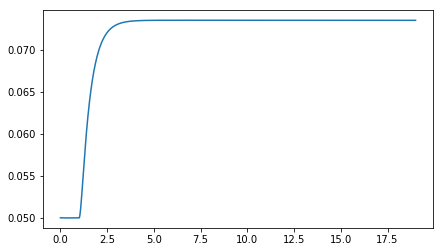

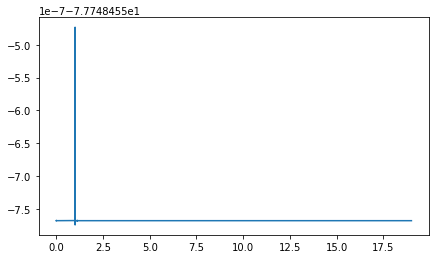

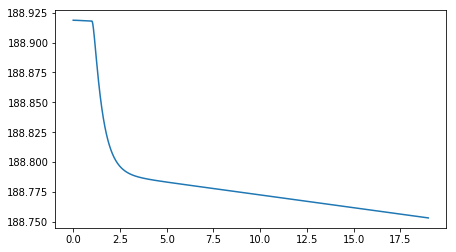

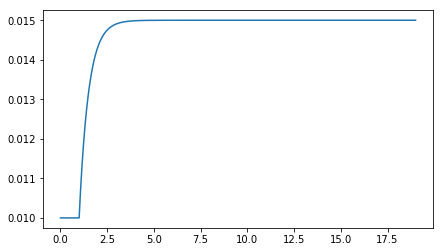

In [200]:
if __name__ == '__main__':
    aa = SingleCellCalciumModelSimple()
    sol = aa.step()
    c = sol[:,0]
    c_t = sol[:,1]
    ip = sol[:,2]
    v = sol[:,3]
    m = sol[:,4]
    h = sol[:,5]
    aa.plot(c)
    aa.plot(v)
    aa.plot((c_t - c)*aa.gamma)
    aa.plot(ip)

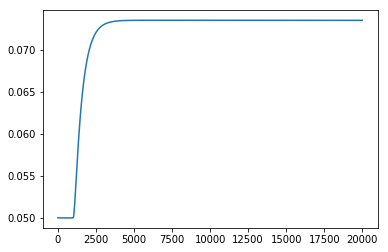

In [201]:
plt.plot(c)

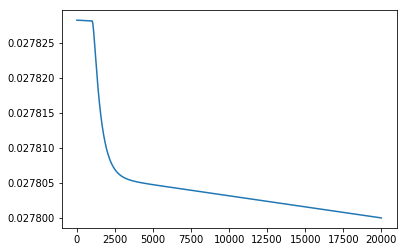

In [202]:
plt.plot(aa.i_leak(c, c_t))

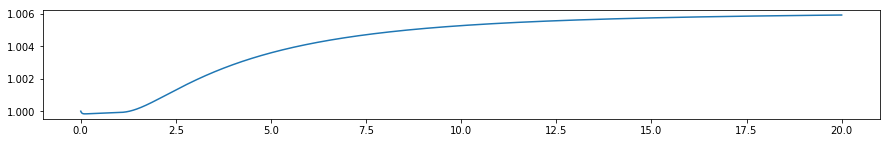

In [206]:
plt.figure(figsize = (15,2))
plt.plot(aa.time, FluorescenceEncoder(c, T, dt).step())
plt.show()